In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv'
df = pd.read_csv(url)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Q1:  Do smokers have higher insurance charges than non-smokers?

NH: Smokers and Non-Smokers have statistically insignificant differences in insurance rates.

AH: There is a significant difference in insurance rates between smokers and non-smokers. 

Alpha = 0.05

T-Test will be completed on this data

In [3]:
# see how many smokers/nonsmokers
df['smoker'].value_counts()



no     1064
yes     274
Name: smoker, dtype: int64

In [4]:
smoker_df = df.loc[df['smoker']== 'yes'].copy()
no_smoker_df = df.loc[df['smoker']== 'no'].copy()

In [5]:
smoker_rate = smoker_df['charges']
no_smoker_rate = no_smoker_df['charges']

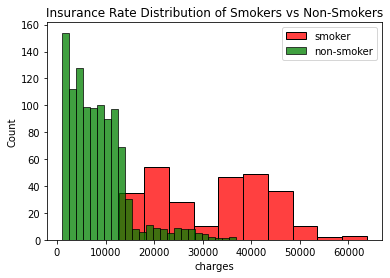

In [6]:
sns.histplot(smoker_rate, color = 'red', label = 'smoker')
sns.histplot(no_smoker_rate, color = 'green', label = 'non-smoker')
plt.title('Insurance Rate Distribution of Smokers vs Non-Smokers')
plt.legend()

In [7]:
# Check for outliers in weight for smoker group
zscores= stats.zscore(smoker_rate)
outliers = abs(zscores)>3
np.sum(outliers)



0

In [8]:
# check for outliers in weight for nonsmoker group
zscores= stats.zscore(no_smoker_rate)
outliers = abs(zscores)>3
np.sum(outliers)


24

In [9]:
# remove outlier for nonsmoker group
no_smoker_rate = no_smoker_rate[(np.abs(stats.zscore(no_smoker_rate)) < 3)]



In [10]:
# test the smoker group for normality
result_smoker_rate = stats.normaltest(smoker_rate)
result_smoker_rate


NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [11]:
result_non_smoker_rate = stats.normaltest(no_smoker_rate)
result_non_smoker_rate

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

**Both distributions are not normal, but sample sizes are large enough**

In [12]:
# Test for equal variance
result = stats.levene(smoker_rate, no_smoker_rate)
result


LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

**Will need to set equal variance to False**

In [13]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(smoker_rate, no_smoker_rate, equal_var = False)
result



Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

*The p-value is less than our alpha value, so we will reject the null hypothesis, and accept the alternate hypothesis that there is, in fact, a statistically significant difference in insurance charges between smokers and non-smokers.*

### Q2: Are men more likely to smoke than women?

NH: There is no statistical difference in the likelihood of smoking between men and women.

AH: There is a statistically significant difference between men and women and their likelihood of smoking.

Alpha = 0.05

Chi-Square test

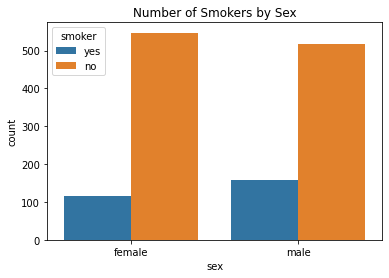

In [14]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Sex");

In [15]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [16]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [17]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

*We will reject the null hypothesis, and accept the alternate hypothesis, that there is a statistically significant difference between genders and smoking habits.*

### Q3:  Do different regions have different charges, on average?

NH: There is no significant difference in insurance charges across regions.

AH: There is a statistically significant difference in insurance charges among the regions sampled.

Alpha = 0.05

ANOVA

In [18]:
#see how many data entries per region
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [19]:
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [20]:
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [21]:
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


**No region has a normal distribution, but the large sample size allows us to proceed with the test**

In [22]:
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

**do not meet the equal variance assumption**

In [23]:
result = stats.stats.kruskal(*groups.values())
result

C:\Users\svaze\AppData\Local\Temp\ipykernel_13364\1602800938.py:1: DeprecationWarning: Please use `kruskal` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  result = stats.stats.kruskal(*groups.values())


KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

*We  fail to reject the null hypothesis,meaning there is no statistically significant difference between regions in insurance charges.*